In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import statsmodels.api as sm

In [47]:
DIR = "data/round-1/"

In [5]:
df1 = pd.read_csv(DIR+"prices_round_1_day_-2.csv", delimiter=';')
df2 = pd.read_csv(DIR+"prices_round_1_day_-1.csv", delimiter=';')
df3 = pd.read_csv(DIR+"prices_round_1_day_0.csv", delimiter=';')
PnL = pd.read_csv(DIR+"prices_day_1.csv", delimiter=';')

In [6]:
price = pd.concat((df1, df2, df3, PnL))

In [ ]:
RESIN = price.loc[price["product"]=="RAINFOREST_RESIN"].reset_index(drop=True)
KELP = price.loc[price["product"]=="KELP"].reset_index(drop=True)
SQUID = price.loc[price["product"]=="SQUID_INK"].reset_index(drop=True)

In [8]:
mp = get_midprice_mm(KELP)
KELP["mid_price"] = mp
mp2 = get_midprice_mm(SQUID)
SQUID["mid_price"] = mp2

In [9]:
kelp = KELP.loc[KELP["day"]==0]
squid = SQUID.loc[SQUID["day"]==0]

In [127]:
# # get price data

# infile = r"data/round-1/log1.log"
# fp = open(infile)
# start = False
# start_signal = "Activities log"
# end_signal = "Trade History"
# outfile = DIR+"log1-prices.txt"

# with open(outfile, "w") as f:

#     for line in fp:

#         if not start:
#             if start_signal in line:
#                 start = True

#         elif start:
#             if end_signal in line:
#                 break
            
#             f.write(line)
             
# f.close()
# fp.close()


In [ ]:
# the entire trade history (not just own trades)
infile = r"data/round-1/log1.log"
hist = get_tradehistory(infile)
# resin_hist = get_mytrades(hist)
kelp_hist = get_mytrades(hist, "KELP")
kelp_hist = kelp_hist.merge(kelp[["timestamp", "mid_price"]], on="timestamp", how="left")
# squid_hist = get_mytrades(hist, "SQUID_INK")
# squid_hist = squid_hist.merge(squid[["timestamp", "mid_price"]], on="timestamp", how="left")

### RESIN

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(kelp["timestamp"]/100, PnL.loc[PnL["product"]=="RAINFOREST_RESIN"]["profit_and_loss"], label="with mm bids")
plt.legend()
plt.show()

### KELP

In [ ]:
plt.figure(figsize=(10,3))
KELP["mid_price"].plot()
plt.axvline(10000, ls='dashed', lw=1)
plt.axvline(20000, ls='dashed', lw=1)
plt.axvline(30000, ls='dashed', lw=1)


In [132]:
kelp_buy = kelp_hist.loc[kelp_hist["buyer"]=="SUBMISSION"]
kelp_sell = kelp_hist.loc[kelp_hist["seller"]=="SUBMISSION"]
buy_time_kelp = list(kelp_buy["timestamp"])
buy_price_kelp = list(kelp_buy["price"])
sell_time_kelp = list(kelp_sell["timestamp"])
sell_price_kelp = list(kelp_sell["price"])

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(kelp["timestamp"]/100, kelp["mid_price"])
plt.plot(np.array(sell_time_kelp)/100, sell_price_kelp, lw=0, ms=10, marker='.', label="live sell")
plt.plot(np.array(buy_time_kelp)/100, buy_price_kelp, lw=0, ms=10, marker='.', label="live buy")
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(kelp["timestamp"]/100, PnL.loc[PnL["product"]=="KELP"]["profit_and_loss"])
plt.show()

### SQUID

Series and its (standardised) difference

In [ ]:
plt.figure(figsize=(10,3))
SQUID["mid_price"].plot()
plt.axvline(10000, ls='dashed', lw=1)
plt.axvline(20000, ls='dashed', lw=1)
plt.axvline(30000, ls='dashed', lw=1)


plt.figure(figsize=(8,2))
diff_s = SQUID["mid_price"].diff().dropna()
diff_s = (diff_s - diff_s.mean()) / diff_s.std()
diff_s.plot()
plt.ylim((-20,20))

Is it mean reverting?

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(SQUID["mid_price"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

The difference is stationary and mean-reverting!

In [ ]:
result = adfuller(diff_s)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

#### KELP

In [ ]:
plt.figure(figsize=(8,2))
diff_k = KELP["mid_price"].diff().dropna()
diff_k = (diff_k - diff_k.mean()) / diff_k.std()
diff_k.plot()

Same story, series itself is not stationary but its difference is!

In [ ]:
result = adfuller(KELP["mid_price"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
result = adfuller(diff_k)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

Sadly no cointegration between them

In [38]:
y = SQUID["mid_price"]
x = KELP["mid_price"]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
residuals = model.resid

In [ ]:
result = adfuller(residuals)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

### Mean reversion strategy

#### Bollinger band

In [11]:
class TRADE_SQUID:
    def __init__(self, slow=26, fast=12, signal=9):  
        self.slow = slow
        self.fast = fast
        self.signal = signal
        self.squid_current = None
        self.squid_previous = None
        self.squid_diff = []
        self.squid_flag = False
        self.squid_upper = 0
        self.squid_lower = 0
        self.alpha_fast = 2 / (fast + 1)
        self.alpha_slow = 2 / (slow + 1)
        self.alpha_signal = 2 / (signal + 1)
        self.ema_fast = None
        self.ema_slow = None
        self.macd = None
        self.buy_times = []
        self.sell_times = []
        self.upper_band = []
        self.lower_band = []
    

    def step(self, time, fairprice, window=20, mult=2., threshold=1., hits=3):
        self.squid_current = fairprice
        if self.squid_previous is not None:
            self.squid_diff.append(self.squid_current - self.squid_previous)
        self.squid_previous = self.squid_current

        if not self.squid_flag:
            if len(self.squid_diff) >= window:
                self.squid_flag = True
        else:
            assert len(self.squid_diff) == window, "length incorrect"


        if len(self.squid_diff) > 0:
            current_diff = self.squid_diff[-1]
            if self.ema_fast is None:
                self.ema_fast = current_diff
                self.ema_slow = current_diff
                self.macd = self.ema_signal = 0 
            else:
                self.ema_fast = self.alpha_fast * current_diff + (1 - self.alpha_fast) * self.ema_fast
                self.ema_slow = self.alpha_slow * current_diff + (1 - self.alpha_slow) * self.ema_slow
                self.ema_signal = self.alpha_signal * self.macd + (1 - self.alpha_signal) * self.ema_signal
                self.macd = self.ema_fast - self.ema_slow
            
        if self.squid_flag:
            current_diff = self.squid_diff[-1]
            sma = np.mean(np.array(self.squid_diff))
            upper = sma + mult * np.std(np.array(self.squid_diff))
            lower = sma - mult * np.std(np.array(self.squid_diff))

            self.upper_band.append(upper)
            self.lower_band.append(lower)

            price_move =  (upper - lower) * threshold
            if current_diff >= upper + price_move or current_diff <= lower - price_move:
                if current_diff >= upper + price_move:
                    self.squid_upper += 1
                    # self.squid_lower = 0
                if current_diff <= lower - price_move:
                    self.squid_lower += 1
                    # self.squid_upper = 0
            else:
                self.squid_upper = 0
                self.squid_lower = 0
            # buy/sell when midprice touches upper/lower band N=hits number of times consecutively
            if self.squid_lower >= hits and self.macd > self.ema_signal:
                self.buy_times.append(time)
            if self.squid_upper >= hits and self.macd < self.ema_signal:
                self.sell_times.append(time)
                
            self.squid_diff = self.squid_diff[1:]


In [53]:
# times = SQUID.index
# prices = SQUID["mid_price"]
# sell = SQUID["bid_price_1"]
# buy= SQUID["ask_price_1"]


times = squid.index
prices = squid["mid_price"]
sell = squid["bid_price_1"]
buy= squid["ask_price_1"]

In [62]:
w = 20
squid_trader = TRADE_SQUID(slow=20, fast=12, signal=0)
for time in times:
    squid_trader.step(time, prices[time], window=w, mult=1.5, threshold=0.0, hits=1)

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(times, prices, alpha=0.5)
plt.plot(squid_trader.sell_times, sell[squid_trader.sell_times], lw=0, ms=5, marker='.', label="sell")
plt.plot(squid_trader.buy_times, buy[squid_trader.buy_times], lw=0, ms=5, marker='.', label="buy")
plt.legend()

#### Z-score

In [442]:
class OnlineZScore:
    def __init__(self, window, threshold, hits=1):
        self.window = window
        self.threshold = threshold
        self.hits = hits
        self.upper = 0
        self.current = None
        self.previous = None
        self.lower = 0
        self.prices = []
        self.long = []
        self.short = []

    def update(self, time, price, diff=False):

        if diff:
            self.current = price
            if self.previous is not None:
                self.prices.append(self.current - self.previous)
            self.previous = price
        else:
            self.prices.append(price)

        if len(self.prices) > self.window:
            self.prices.pop(0)

        if len(self.prices) < self.window:
            return 0.0

        arr = np.array(self.prices)
        mean = np.mean(arr)
        std = np.std(arr)

        if std == 0:
            return 0.0

        z = (self.prices[-1] - mean) / std

        if z < -self.threshold:
            self.lower += 1
            self.upper = 0
        elif z > self.threshold:
            self.upper += 1
            self.lower = 0
        else:
            self.lower = 0
            self.upper = 0
        
        if self.upper >= self.hits:
            self.short.append(time)
        elif self.lower >= self.hits:
            self.long.append(time)
        
        return z


In [443]:
prices = list(squid["mid_price"])
bid = list(squid["bid_price_1"])
ask = list(squid["ask_price_1"])

In [444]:
def find_consecutive(indices, N):
    consecutive = []
    for i in range(len(indices) - N + 1):
        if all(indices[i + j] + 1 == indices[i + j + 1] for j in range(N - 1)):
            consecutive.append(indices[i])
    return consecutive

In [465]:
hits = 2
hits_signal = 1
scorer = OnlineZScore(20, 1.25, hits)
for i in range(len(prices)):
    scorer.update(i, prices[i])
sell_signal = find_consecutive(scorer.short, hits_signal)
buy_signal = find_consecutive(scorer.long, hits_signal)

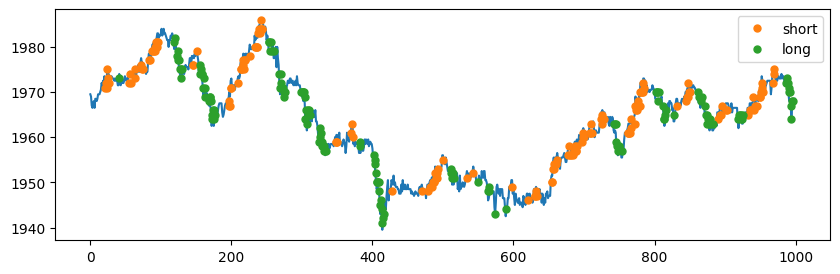

In [466]:
plt.figure(figsize=(10,3))
plt.plot(prices)
plt.plot(sell_signal, np.array(bid)[sell_signal], lw=0, ms=10, marker='.', label="short")
plt.plot(buy_signal, np.array(ask)[buy_signal], lw=0, ms=10, marker='.', label="long")
plt.legend()

#### OU trader

In [ ]:
class OUTrader:
    def __init__(self, z_entry=1.0, z_exit=0.2, alpha=0.05):
        self.alpha = alpha
        self.ema = None
        self.ema_var = 1e-5
        self.prev_x = None
        self.sum_xx = 0.0
        self.sum_xy = 0.0
        self.ab_count = 0

        self.z_entry = z_entry
        self.z_exit = z_exit
        self.position = 0  # -1 short, 1 long, 0 flat

    def update(self, x):
        if self.ema is None:
            self.ema = x
            self.ema_var = 0.0
        else:
            delta = x - self.ema
            self.ema += self.alpha * delta
            self.ema_var = (1 - self.alpha) * (self.ema_var + self.alpha * delta**2)

        if self.prev_x is not None:
            self.sum_xx += self.prev_x ** 2
            self.sum_xy += self.prev_x * x
            self.ab_count += 1

        self.prev_x = x

    def get_params(self):
        if self.ab_count < 10 or self.sum_xx == 0:
            return None

        a = self.sum_xy / self.sum_xx
        a = np.clip(a, 1e-5, 0.999)
        b = self.ema * (1 - a)
        theta = -np.log(a)
        sigma = np.sqrt(self.ema_var) * np.sqrt(2 * theta / (1 - a**2))
        mu = b / (1 - a)

        return mu, theta, sigma

    def get_zscore(self, x):
        params = self.get_params()
        if params is None:
            return None
        mu, _, sigma = params
        return (x - mu) / sigma if sigma > 1e-5 else 0.0

    def signal(self, x):
        z = self.get_zscore(x)
        if z is None:
            return "HOLD"

        if self.position == 0:
            if z > self.z_entry:
                self.position = -1
                return "SELL"
            elif z < -self.z_entry:
                self.position = 1
                return "BUY"
        elif self.position == 1 and z > -self.z_exit:
            self.position = 0
            return "CLOSE"
        elif self.position == -1 and z < self.z_exit:
            self.position = 0
            return "CLOSE"

        return "HOLD"


In [372]:
prev = list(SQUID.loc[SQUID["day"]==-1]["mid_price"])[-10:]

In [380]:
ou_trader = OUTrader(z_entry=1., z_exit=0.2, alpha=0.05)   

for price in prev:
    ou_trader.update(price)


buy_times, sell_times, exit_times = [], [], []
pos = 0

for i in range(len(prices)):
    ou_trader.update(prices[i])
    action = ou_trader.signal(prices[i])

    if action == "CLOSE":
        exit_times.append(i)
        pos = 0
    elif action == "BUY":
        buy_times.append(i)
        pos += 1
    elif action == "SELL":
        sell_times.append(i)
        pos -= 1


In [ ]:
plt.figure(figsize=(10,3))
plt.plot(prices)
plt.plot(sell_times, np.array(bid)[sell_times], lw=0, ms=10, marker='.', label="short")
plt.plot(buy_times, np.array(ask)[buy_times], lw=0, ms=10, marker='.', label="long")
plt.plot(exit_times, np.array(ask)[exit_times], lw=0, ms=10, marker='.', label="exit")
plt.legend()

### Forecast engine

In [633]:
DIR2024= "data/round-1/2024/"

In [650]:
df1a = pd.read_csv(DIR2024+"prices_round_1_day_-2.csv", delimiter=";")
df2a = pd.read_csv(DIR2024+"prices_round_1_day_-1.csv", delimiter=";")
df3a = pd.read_csv(DIR2024+"prices_round_1_day_0.csv", delimiter=";")
df4a = pd.read_csv(DIR2024+"prices_day_1b.csv", delimiter=";")

In [652]:
price = pd.concat((df1a, df2a, df3a, df4a))
STARFRUIT = price.loc[price["product"]=="STARFRUIT"]
mp_sf = get_midprice_mm(STARFRUIT)
STARFRUIT.loc[:, "mid_price"] = mp_sf

In [ ]:
plt.plot((mp_sf - mp_sf.mean())/mp_sf.std(), label="2024")
plt.plot((SQUID["mid_price"] - SQUID["mid_price"].mean())/SQUID["mid_price"].std(), label="2025")
plt.legend()

In [796]:
from sklearn.preprocessing import StandardScaler

y = SQUID["mid_price"].diff().dropna().array
X = np.diff(mp_sf)[:len(y)]

scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, 1))

split = int(len(y) * 0.8)

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()


In [804]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, reg_lambda=0.1, reg_alpha=0)
# model = XGBRegressor(n_estimators=150, max_depth=10, learning_rate=0.05)
model.fit(X_train, y_train)

y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

In [ ]:
plt.plot(y)
plt.plot(range(split, len(y)), y[split:], label="true")
plt.plot(range(split, len(y)), y_pred, label="predicted")
plt.legend()
plt.ylim((-20,20))

#### MISSION ABORT

#### Live performance

In [467]:
# day0 prices
squid = squid.loc[squid["timestamp"] <= 99900].reset_index(drop=True)

In [468]:
# # day 1 prices
# squid1 = PnL.loc[PnL["product"]=="SQUID_INK"]
# squid1 = squid1.loc[squid1["timestamp"] <= 99900].reset_index(drop=True)

In [475]:
infile = r"data/round-1/squid.log"
hist = get_tradehistory(infile)
squid_hist = get_mytrades(hist, "SQUID_INK")
squid_hist = squid_hist.merge(squid[["timestamp", "mid_price"]], on="timestamp", how="left")

In [476]:
squid_buy = squid_hist.loc[squid_hist["buyer"]=="SUBMISSION"]
squid_sell = squid_hist.loc[squid_hist["seller"]=="SUBMISSION"]
buy_time = list(squid_buy["timestamp"])
buy_price = list(squid_buy["price"])
sell_time = list(squid_sell["timestamp"])
sell_price = list(squid_sell["price"])

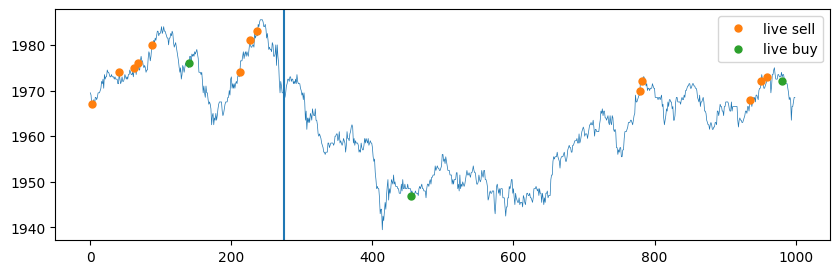

In [485]:
plt.figure(figsize=(10,3))
plt.plot(squid["timestamp"]/100, squid["mid_price"], lw=0.5)
plt.plot(np.array(sell_time)/100, sell_price, lw=0, ms=10, marker='.', label="live sell")
plt.plot(np.array(buy_time)/100, buy_price, lw=0, ms=10, marker='.', label="live buy")

plt.axvline(274)
plt.legend()
plt.show()
# plt.figure(figsize=(10,3))
# plt.plot(squid["timestamp"]/100, PnL.loc[PnL["product"]=="SQUID_INK"]["profit_and_loss"])
# plt.show()

#### Correlation analysis and prediction

In [9]:
k = (KELP["mid_price"] - KELP["mid_price"].mean()) / KELP["mid_price"].std()
s = (SQUID["mid_price"] - SQUID["mid_price"].mean()) / SQUID["mid_price"].std()

In [ ]:
k.corr(s)

In [ ]:
plt.figure(figsize=(10,3))
k.plot()
s.plot()

In [60]:
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame({'kelp': KELP["mid_price"], 'squid': SQUID["mid_price"]})

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)


time_step = 60  

X, y = create_dataset(scaled_data, time_step)

train_size = X.shape[0] - 1000
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=2)) 

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)


In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)


In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'RMSE: {rmse}')


In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(kelp["timestamp"]/100, kelp["mid_price"], label="true")
plt.plot(y_pred_rescaled[:, 0], label='predicted')
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(squid["timestamp"]/100, squid["mid_price"], label="true")
plt.plot(y_pred_rescaled[:, 1], label='predicted')
plt.legend()
plt.show()